Importing the Pyhton Modules

In [60]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
import pandas as pd

import re
import nltk

Reading the data from justice.csv file and dropping the NaN values

In [61]:
df = pd.read_csv('justice.csv', delimiter=',', encoding = "utf8")
df.dropna(inplace=True)
df.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
5,5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


In [62]:
df_imp = df.copy()
df_imp.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
5,5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


In [63]:
df_imp.drop(columns=['Unnamed: 0', 'docket','name','first_party','second_party', 
                 'facts_len', 'majority_vote', 'minority_vote', 'href', 'ID','term'], inplace=True)
df_imp.columns

Index(['facts', 'first_party_winner', 'decision_type', 'disposition',
       'issue_area'],
      dtype='object')

Splitting the data across multiple arrays to differentiate between the features to be used for NLP and others to be used for Classification

In [64]:
df_facts = df_imp['facts']
df_cat = df_imp[['decision_type', 'disposition', 'issue_area']]
df_target = df_imp['first_party_winner']

In [65]:
df_cat.reset_index(drop=True, inplace=True)
df_target.reset_index(drop=True, inplace=True)
df_facts.reset_index(drop=True, inplace=True)

Label Encoding of the Target Variable

In [66]:
label_encoder = preprocessing.LabelEncoder()
df_target= label_encoder.fit_transform(df_target)
df_target = pd.DataFrame(df_target, columns=['first_party_winner'])
df_target

,first_party_winner
0,1
1,1
2,1
3,1
4,1
...,...
3093,1
3094,1
3095,0
3096,1


In [67]:
df_cat_target = pd.concat([df_cat, df_target], axis=1, join='inner')
# df_cat_target

In [68]:
df_facts = pd.DataFrame(df_facts, columns=['facts'])

In [69]:
df_facts['facts'] = df_facts['facts'].str.replace(r'<[^<>]*>', '', regex=True)
# df_facts

In [70]:
corpus = df_facts["facts"]
tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))   

In [71]:
ps = nltk.stem.porter.PorterStemmer()
lem = nltk.stem.wordnet.WordNetLemmatizer()

In [ ]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords

Function for Text Preprocessing (Tokenizing, Removing Stopwords, Stemming , Lemmatisation)

In [73]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, stopwords=None):
    # toLowerCase, removing Punctuation and white spaces
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    # Tokenize 
    lst_text = text.split()

    # removing Stopwords
    if stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    stopwords]
                
    # Stemming 
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    # Lemmatisation
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    # returning final String
    text = " ".join(lst_text)
    return text

In [76]:
df_facts["facts_clean"] = df_facts["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, stopwords=stopwords))

In [19]:
df_facts.iloc[0]

facts          Joan Stanley had three children with Peter Sta...
facts_clean    joan stanley three child peter stanley stanley...
Name: 0, dtype: object

In [77]:
df_facts_target = pd.concat([df_facts,df_target['first_party_winner']],axis=1, join='inner')
df_facts_target.columns

Index(['facts', 'facts_clean', 'first_party_winner'], dtype='object')

Data Analysis

Target Variable Result Distribution

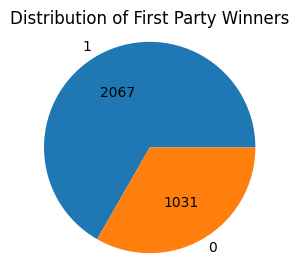

In [21]:
value_counts = df_facts_target["first_party_winner"].value_counts()

import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3)) 
plt.pie(value_counts, labels=value_counts.index, autopct=lambda p: '{:.0f}'.format(p * sum(value_counts) / 100))
plt.title("Distribution of First Party Winners") 
plt.axis('equal')  
plt.show() 

Showing Word Length for Facts to be used for Analysis and Prediction

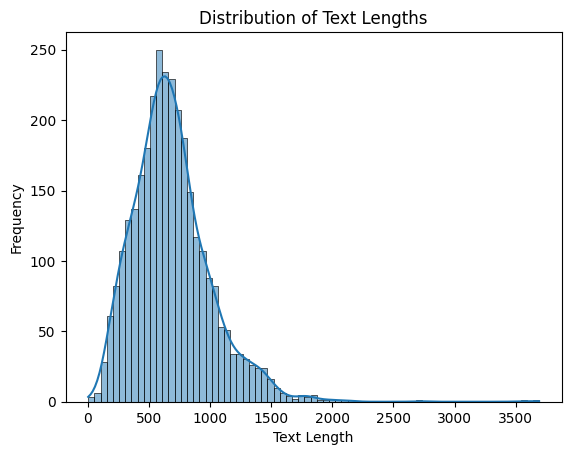

In [22]:
import seaborn as sns

df_facts['text_length'] = df_facts['facts_clean'].apply(len)

sns.histplot(data=df_facts, x='text_length', kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

Plotting the various Unigrams and Bigrams, occuring most frequently in our facts corpus

In [24]:
def plot_uni_bi(y):
    corpus = df_facts_target[df_facts_target["first_party_winner"]== y]["facts_clean"]
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
    fig.suptitle("Most frequent words", fontsize=15)
    fig.subplots_adjust(hspace=0.5)  

    # Unigrams
    dic_words_freq = nltk.FreqDist(lst_tokens)
    dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
    ax[0].barh(dtf_uni["Word"][:10], dtf_uni["Freq"][:10], color='skyblue')
    ax[0].invert_yaxis()
    ax[0].set_title("Unigrams")
    for i, v in enumerate(dtf_uni["Freq"][:10]):
        ax[0].text(v + 3, i, str(v), ha='left', va='center')
    ax[0].set_ylabel("Word")
    ax[0].set_xlabel("Frequency")

    # Bigrams
    dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
    dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
    dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                    string for string in x) )
    ax[1].barh(dtf_bi["Word"][:10], dtf_bi["Freq"][:10], color='lightgreen')
    ax[1].invert_yaxis()
    ax[1].set_title("Bigrams")
    for i, v in enumerate(dtf_bi["Freq"][:10]):
        ax[1].text(v + 3, i, str(v), ha='left', va='center')
    ax[1].set_ylabel("Bigram")
    ax[1].set_xlabel("Frequency")

    plt.show()


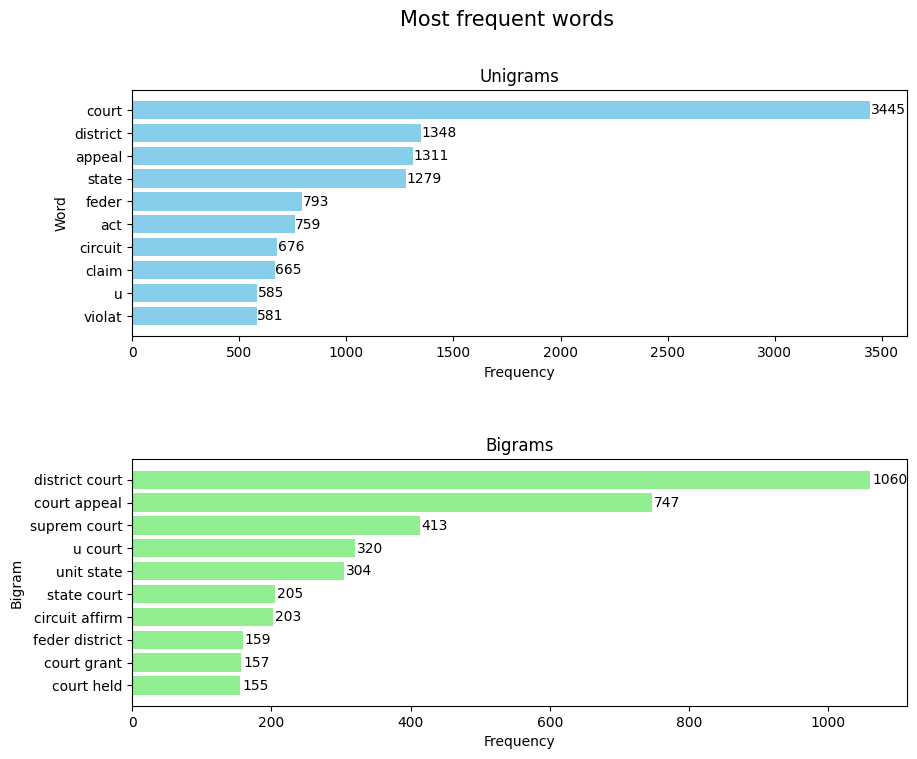

In [25]:
plot_uni_bi(0)

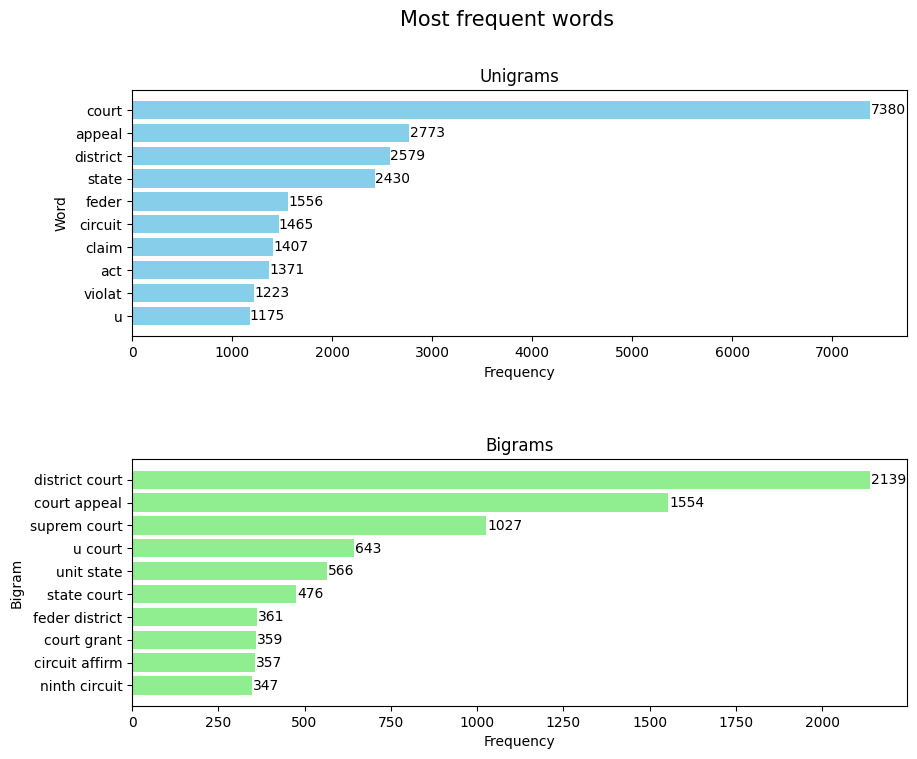

In [26]:
plot_uni_bi(1)

In [27]:
import wordcloud
import gensim.downloader as gensim_api
import gensim
import seaborn as sb

Word Cloud showing the frequency of most occuring words

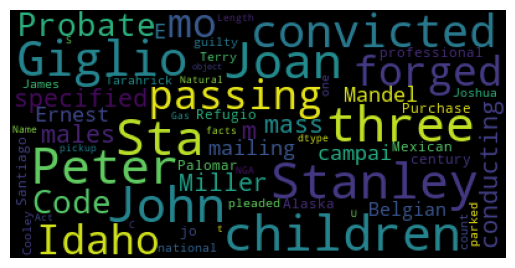

In [28]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=40)
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

In [79]:
df_facts_target.columns

Index(['facts', 'facts_clean', 'first_party_winner'], dtype='object')

In [80]:
df_catRaw_facts_target=pd.concat([df_facts_target,df_cat],axis=1,join='inner')
df_catRaw_facts_target

,facts,facts_clean,first_party_winner,decision_type,disposition,issue_area
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,1,majority opinion,reversed/remanded,Civil Rights
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1,majority opinion,reversed/remanded,Due Process
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,1,majority opinion,reversed/remanded,Civil Rights
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1,majority opinion,vacated/remanded,First Amendment
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1,majority opinion,reversed,First Amendment
...,...,...,...,...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...,1,majority opinion,reversed/remanded,Civil Rights
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...,1,majority opinion,reversed/remanded,Criminal Procedure
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...,0,majority opinion,affirmed,Criminal Procedure
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...,1,majority opinion,vacated/remanded,Civil Rights


In [81]:
xFeatures = df_catRaw_facts_target[['facts_clean','decision_type','disposition', 'issue_area']]
yLabel = df_catRaw_facts_target['first_party_winner']

One Hot Encoding of Categorical input features like Decision Type, Disposition, Issue Area

In [82]:
df_dec = pd.get_dummies(df_cat['decision_type'])
df_dec

,dismissal - improvidently granted,dismissal - moot,dismissal - other,equally divided,majority opinion,opinion of the court,per curiam,plurality opinion
0,False,False,False,False,True,False,False,False
1,False,False,False,False,True,False,False,False
2,False,False,False,False,True,False,False,False
3,False,False,False,False,True,False,False,False
4,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...
3093,False,False,False,False,True,False,False,False
3094,False,False,False,False,True,False,False,False
3095,False,False,False,False,True,False,False,False
3096,False,False,False,False,True,False,False,False


In [83]:
df_disp = pd.get_dummies(df_cat['disposition'])
df_disp

,affirmed,none,reversed,reversed in-part,reversed in-part/remanded,reversed/remanded,vacated,vacated in-part/remanded,vacated/remanded
0,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,True,False,False,False
2,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,True
4,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
3093,False,False,False,False,False,True,False,False,False
3094,False,False,False,False,False,True,False,False,False
3095,True,False,False,False,False,False,False,False,False
3096,False,False,False,False,False,False,False,False,True


In [84]:
df_area = pd.get_dummies(df_cat['issue_area'])
df_area

,Attorneys,Civil Rights,Criminal Procedure,Due Process,Economic Activity,Federal Taxation,Federalism,First Amendment,Interstate Relations,Judicial Power,Miscellaneous,Privacy,Private Action,Unions
0,False,True,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3094,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3095,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3096,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [85]:
df_dec_disp_area=pd.concat([df_dec,df_disp],axis=1,join='inner')
df_dec_disp_area

,dismissal - improvidently granted,dismissal - moot,dismissal - other,equally divided,majority opinion,opinion of the court,per curiam,plurality opinion,affirmed,none,reversed,reversed in-part,reversed in-part/remanded,reversed/remanded,vacated,vacated in-part/remanded,vacated/remanded
0,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
3094,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
3095,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False
3096,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True


In [86]:
df_dec_disp_area_target=pd.concat([df_dec_disp_area,df_catRaw_facts_target['first_party_winner']],axis=1,join='inner')

In [87]:
vectorize=CountVectorizer()

In [90]:
df_catRaw_facts_target

,facts,facts_clean,first_party_winner,decision_type,disposition,issue_area
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,1,majority opinion,reversed/remanded,Civil Rights
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1,majority opinion,reversed/remanded,Due Process
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,1,majority opinion,reversed/remanded,Civil Rights
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1,majority opinion,vacated/remanded,First Amendment
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1,majority opinion,reversed,First Amendment
...,...,...,...,...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...,1,majority opinion,reversed/remanded,Civil Rights
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...,1,majority opinion,reversed/remanded,Criminal Procedure
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...,0,majority opinion,affirmed,Criminal Procedure
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...,1,majority opinion,vacated/remanded,Civil Rights


Converts facts into numerical matrix DataFrame.

In [91]:
count_matrix = vectorize.fit_transform(df_catRaw_facts_target['facts_clean'])
count_array = count_matrix.toarray()
data_facts_vectorized = pd.DataFrame(data=count_array, columns=vectorize.get_feature_names_out())

In [92]:
data_final = pd.concat([data_facts_vectorized,df_dec_disp_area_target],axis=1,join='inner')
data_final.drop(columns=data_final.columns[-1],  axis=1,  inplace=True)
data_final=pd.concat([data_final,df_catRaw_facts_target['first_party_winner']],axis=1,join='inner')

In [93]:
data_final

,011119,0125,01657,019,02,036539,04,041352,041581,045323,...,affirmed,none,reversed,reversed in-part,reversed in-part/remanded,reversed/remanded,vacated,vacated in-part/remanded,vacated/remanded,first_party_winner
0,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,1
1,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,1
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,1
3,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,1
4,0,0,0,0,0,0,0,0,0,0,...,False,False,True,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,1
3094,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,True,False,False,False,1
3095,0,0,0,0,0,0,0,0,0,0,...,True,False,False,False,False,False,False,False,False,0
3096,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,False,True,1


Train Test Split

In [94]:
X_train, X_test, y_train, y_test = train_test_split(data_final.drop(columns=['first_party_winner']),
                                                    data_final['first_party_winner'], 
                                                    test_size=0.2,random_state=42)


In [95]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_final = scaler.fit_transform(data_final)

Applies Latent Dirichlet Allocation for topic modeling

In [96]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=40, random_state=0)

In [97]:
lda_data_train = pd.DataFrame(data=lda.fit_transform(X_train))
lda_data_test = pd.DataFrame(data=lda.transform(X_test))

In [98]:
lda_data_test

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.000352,0.020197,0.088391,0.118187,...,0.000352,0.000352,0.000352,0.000352,0.019516,0.000352,0.000352,0.000352,0.000352,0.000352
1,0.000243,0.000243,0.000243,0.000243,0.000243,0.024078,0.000243,0.403371,0.000243,0.000243,...,0.000243,0.071566,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243,0.000243
2,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.074453,...,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.123917,0.000160,0.000160
3,0.000221,0.144419,0.000221,0.000221,0.000221,0.000221,0.000221,0.000221,0.000221,0.000221,...,0.000221,0.000221,0.049801,0.000221,0.000221,0.108523,0.000221,0.000221,0.000221,0.284084
4,0.001000,0.087243,0.366205,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,...,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.001000,0.135710,0.001000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,0.000625,...,0.000625,0.063106,0.000625,0.000625,0.000625,0.000625,0.000625,0.077363,0.000625,0.000625
616,0.000284,0.000284,0.000284,0.000284,0.000284,0.045697,0.000284,0.000284,0.078038,0.026318,...,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284,0.000284
617,0.000287,0.000287,0.000287,0.000287,0.000287,0.029849,0.000287,0.000287,0.091247,0.000287,...,0.000287,0.000287,0.000287,0.000287,0.140837,0.000287,0.000287,0.000287,0.000287,0.000287
618,0.000123,0.000123,0.000123,0.000123,0.000123,0.000123,0.000123,0.000123,0.000123,0.024054,...,0.000123,0.000123,0.000123,0.000123,0.000123,0.008148,0.000123,0.034354,0.000123,0.000123


Applying the grid search for finding the best parameters for Random Forest Search Algorithm

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = {
    'max_depth': [8,10,12,14],
    'max_features': [60,70,80,90,100],
    'min_samples_leaf': [2, 3, 4],
    'n_estimators': [100, 200, 300]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [99]:
grid_search.fit(lda_data_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 180 candidates, totalling 540 fits


KeyboardInterrupt: 

Random Forest

In [100]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

rand = RandomForestClassifier(max_depth=8, max_features=70, min_samples_leaf=2, n_estimators=100)
rand.fit(lda_data_train, y_train)
y_pred = rand.predict(lda_data_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)


Confusion Matrix:
[[  1 201]
 [  7 411]]
Accuracy: 0.6645161290322581
Precision: 0.4934930423782416
Recall: 0.6645161290322581
F1 Score: 0.5411486436102784


KNN

In [54]:
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

knn = KNeighborsClassifier(n_neighbors=22)

knn.fit(lda_data_train, y_train)

y_pred = knn.predict(lda_data_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

Confusion Matrix:
[[ 31 171]
 [ 41 377]]
Accuracy: 0.6580645161290323
Precision: 0.6040934123433536
Recall: 0.6580645161290323
F1 Score: 0.5999565154016889


XGBoost

In [58]:
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

xgb_model = xgb.XGBClassifier()

xgb_model.fit(lda_data_train, y_train)

y_pred = xgb_model.predict(lda_data_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_test, y_pred, average='weighted')
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

Confusion Matrix:
[[ 43 159]
 [ 86 332]]
Accuracy: 0.6048387096774194
Precision: 0.564472329895101
Recall: 0.6048387096774194
F1 Score: 0.5771308346115773
